In [1]:
import pandas as pd
import numpy as np
import pybaseball as pyb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, atan2, degrees, pi
from scipy.stats import percentileofscore
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
data_2023 = pyb.statcast(start_dt='2023-03-30', end_dt='2023-10-01')

This is a large query, it may take a moment to complete


/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
100%|█████████████████████████████████████████| 186/186 [00:42<00:00,  4.35it/s]


In [3]:
fastballs = data_2023[data_2023['pitch_type'].isin(['FF'])]
fastballs.dropna(subset=['vy0'], inplace=True)
fastballs.dropna(subset=['release_extension'], inplace=True)
fastballs.dropna(subset=['spin_axis'], inplace=True)

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [4]:
def calculate_vaa(row):
    yf = 17/12  # Home plate distance in feet, converted to inches
    ay = row['ay']  # Acceleration in y-dimension for the current pitch
    vy0 = row['vy0']  # Velocity in y-dimension at y=50 feet for the current pitch
    vz0 = row['vz0']  # Velocity in z-dimension at y=50 feet for the current pitch
    az = row['az']  # Acceleration in z-dimension for the current pitch

    vy_f = -sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    return vaa_deg
fastballs['VAA'] = fastballs.apply(calculate_vaa, axis=1)

/var/folders/bf/7kjr62fs6wq3x9hlt0xsr0w40000gn/T/ipykernel_33261/716655449.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['VAA'] = fastballs.apply(calculate_vaa, axis=1)


In [5]:
filtered_ff = fastballs.loc[:, ['ax','ay','az','release_pos_z', 'player_name', 'pfx_z', 'release_spin_rate','plate_x','spin_axis','VAA','release_extension','zone','plate_z','release_speed','release_pos_x','release_pos_y','vx0','vy0','vz0']]

In [6]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

In [7]:
filtered_ff['VRA'] = filtered_ff.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
filtered_ff['HRA'] = filtered_ff.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['release_extension'], x['vx0'], x['ax']), axis=1)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
xvars = ['release_pos_z','VRA','HRA','release_pos_x']
yvar = 'plate_z'

In [10]:
df_to_fit = filtered_ff[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    filtered_ff[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 2)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

172516 172516
57506 57506


In [11]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()

# Fit the model
rf_regressor.fit(X_train, y_train)


RandomForestRegressor()

In [12]:
y_pred = rf_regressor.predict(X_test)

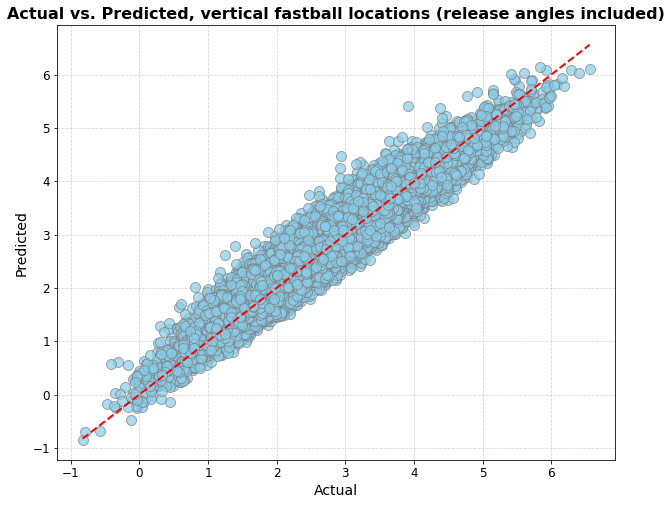

In [13]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, color='skyblue', edgecolors='gray', alpha=0.7, s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Actual vs. Predicted, vertical fastball locations (release angles included)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [14]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
r2

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.9177116698564572

In [15]:
xvars2 = ['release_pos_x','HRA','release_pos_z','VRA']
yvar2 = 'plate_x'

In [16]:
df_to_fit2 = filtered_ff[xvars2+[yvar2]].dropna()

In [17]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    filtered_ff[xvars2], df_to_fit2[yvar2], test_size = 0.25, random_state = 3)

In [18]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train2, y_train2)

RandomForestRegressor()

In [19]:
y_pred2 = rf_regressor.predict(X_test2)

In [20]:
r2_horiz = r2_score(y_test2, y_pred2)
r2_horiz

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.8465110318178046

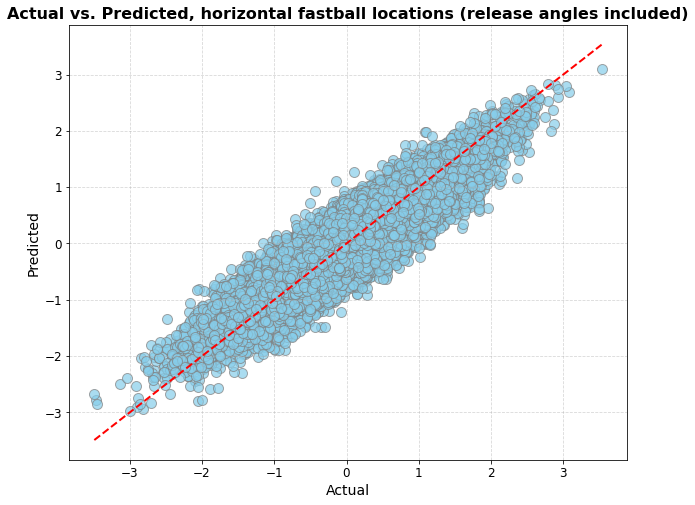

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test2, y_pred2, color='skyblue', edgecolors='gray', alpha=0.7, s=100)
plt.plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Actual vs. Predicted, horizontal fastball locations (release angles included)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [22]:
xvars3 = ['release_pos_z', 'release_extension', 'spin_axis', 'release_spin_rate', 'release_pos_x','release_speed']
yvar3 = 'plate_z'

In [23]:
df_to_fit3 = filtered_ff[xvars3+[yvar3]].dropna()

X_train3, X_test3, y_train3, y_test3 = train_test_split(
    filtered_ff[xvars3], df_to_fit3[yvar3], test_size = 0.25, random_state = 2)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

172516 172516
57506 57506


In [49]:
rf_regressor.fit(X_train3, y_train3)

RandomForestRegressor()

In [50]:
y_pred3 = rf_regressor.predict(X_test3)

In [51]:
r2_vert_no_angles = r2_score(y_test3, y_pred3)
r2_vert_no_angles

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.057197611558813866

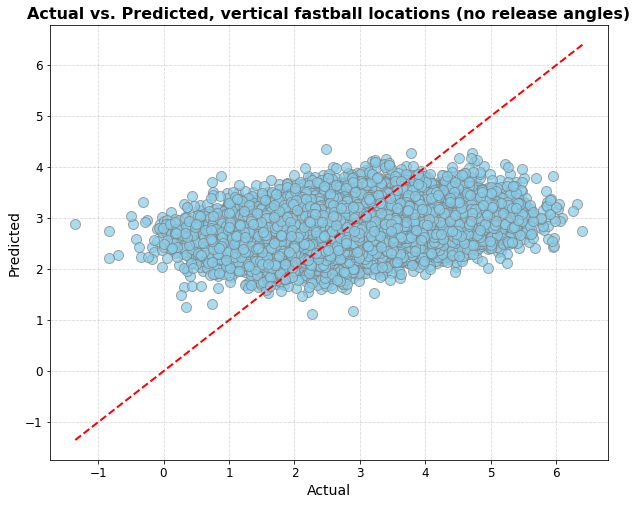

In [55]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test3, y_pred3, color='skyblue', edgecolors='gray', alpha=0.7, s=100)
plt.plot([y_test3.min(), y_test3.max()], [y_test3.min(), y_test3.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Actual vs. Predicted, vertical fastball locations (no release angles)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [56]:
xvars4 = ['release_pos_z', 'release_extension', 'spin_axis', 'release_spin_rate', 'release_pos_x','release_speed','release_pos_x']
yvar4 = 'plate_x'

In [57]:
df_to_fit4 = filtered_ff[xvars4+[yvar4]].dropna()

X_train4, X_test4, y_train4, y_test4 = train_test_split(
    filtered_ff[xvars4], df_to_fit4[yvar4], test_size = 0.25, random_state = 2)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

172192 172192
57398 57398


In [58]:
rf_regressor.fit(X_train4, y_train4)

RandomForestRegressor()

In [59]:
y_pred4 = rf_regressor.predict(X_test4)

In [60]:
r2_horiz_no_angles = r2_score(y_test4, y_pred4)
r2_horiz_no_angles

/Users/michaelrosen/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.053074836195532216

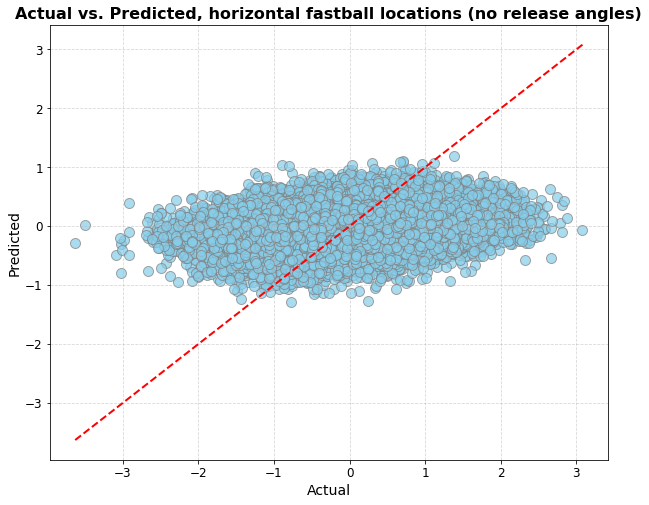

In [62]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test4, y_pred4, color='skyblue', edgecolors='gray', alpha=0.7, s=100)
plt.plot([y_test4.min(), y_test4.max()], [y_test4.min(), y_test4.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.title('Actual vs. Predicted, horizontal fastball locations (no release angles)', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [32]:
X = filtered_ff[['VRA','release_pos_z','HRA','release_pos_x']].astype(float)
y = filtered_ff[['plate_z','plate_x']].astype(float)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

# Fit a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.08145964168122276
R-squared: 0.8650789953544669
